In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [5]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    

In [6]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])

In [7]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [8]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

In [9]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [10]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

C:\Users\varun\anaconda3\envs\torch\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [13]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.22774 | train_accuracy: 0.05808 | valid_accuracy: 0.05714 |  0:00:17s
epoch 1  | loss: 0.78388 | train_accuracy: 0.03543 | valid_accuracy: 0.0354  |  0:00:34s
epoch 2  | loss: 0.73506 | train_accuracy: 0.0357  | valid_accuracy: 0.03559 |  0:00:51s
epoch 3  | loss: 0.71173 | train_accuracy: 0.03585 | valid_accuracy: 0.03566 |  0:01:08s
epoch 4  | loss: 0.69748 | train_accuracy: 0.03561 | valid_accuracy: 0.0355  |  0:01:24s
epoch 5  | loss: 0.68411 | train_accuracy: 0.0356  | valid_accuracy: 0.0355  |  0:01:41s
epoch 6  | loss: 0.67533 | train_accuracy: 0.12261 | valid_accuracy: 0.12381 |  0:01:58s
epoch 7  | loss: 0.66557 | train_accuracy: 0.0635  | valid_accuracy: 0.06441 |  0:02:14s
epoch 8  | loss: 0.65848 | train_accuracy: 0.08809 | valid_accuracy: 0.08809 |  0:02:30s
epoch 9  | loss: 0.65074 | train_accuracy: 0.11824 | valid_accuracy: 0.11732 |  0:02:47s
epoch 10 | loss: 0.64568 | train_accuracy: 0.20514 | valid_accuracy: 0.20543 |  0:03:03s
epoch 11 | loss: 0.64

C:\Users\varun\anaconda3\envs\torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


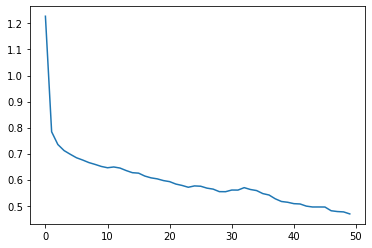

In [14]:
# plot losses
plt.plot(clf.history['loss'])

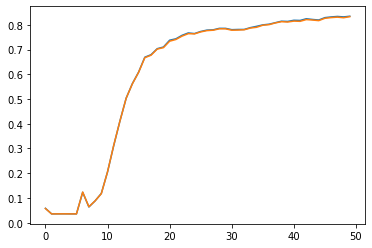

In [15]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [16]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.8327449221296398
FINAL TEST SCORE FOR forest-cover-type : 0.8314845571973185


In [17]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.8314845571973185


In [18]:
clf.feature_importances_

array([1.19196376e-01, 2.40714698e-02, 1.31529022e-02, 6.67400146e-02,
       2.90108211e-03, 1.09392060e-01, 3.82445315e-02, 2.14183268e-02,
       2.60037467e-03, 2.85065883e-02, 3.27991047e-02, 1.31668057e-02,
       1.23266115e-02, 1.85101968e-02, 4.51829389e-03, 2.80143876e-02,
       1.10058639e-02, 5.67718197e-03, 1.93645858e-02, 3.46936180e-03,
       1.30306349e-02, 2.14966827e-03, 1.59243582e-02, 1.71817714e-03,
       2.06839375e-02, 1.30114665e-03, 2.93254101e-02, 9.04166304e-04,
       1.04823202e-02, 6.13405191e-03, 3.08834533e-03, 1.19261885e-02,
       3.18697879e-03, 2.62233513e-03, 1.95308866e-02, 2.82455812e-02,
       1.96066961e-02, 2.24077555e-04, 2.74861768e-03, 1.50455866e-02,
       3.45957379e-06, 1.22685109e-05, 2.49473600e-02, 5.47685017e-02,
       1.51536068e-04, 6.04478385e-02, 8.51458074e-03, 6.82830002e-03,
       2.66661312e-02, 1.33232460e-03, 1.52397403e-02, 1.54129972e-04,
       1.12742168e-03, 1.68511228e-02])